# Compare models on a test set

In [1]:
from fastai.tabular.all import *
import numpy as np

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Load the models

In [2]:
nn_model = load_pickle('models/wideModel.pkl')
rf_model = load_pickle('models/randomForestModel.pkl')

Load the test set

In [3]:
cwd = os.getcwd()
parent = os.path.dirname(cwd)
csv_path = os.path.join(parent, "data/", "test_set.csv")

In [4]:
df = pd.read_csv(csv_path, low_memory=False)
df.head(5)

,p_in,Re,Geometry
0,8.730040,10.50,testCaseRe
1,5.878845,20.00,testCaseRe
2,75.122210,1.00,testCaseRe
3,14.111010,5.75,testCaseRe
4,6.840435,15.25,testCaseRe


Prepare the data in the same way as we did with the training set.

In [5]:
df.Geometry = 'unknown'
df['p_in'] = np.log1p(df['p_in'])
df.head()

,p_in,Re,Geometry
0,2.275218,10.50,unknown
1,1.928451,20.00,unknown
2,4.332340,1.00,unknown
3,2.715424,5.75,unknown
4,2.059294,15.25,unknown


In [6]:
# For Re (Reynolds number)
df['Re_log'] = np.log1p(df['Re'])  # Log transform
df['Re_squared'] = df['Re'] ** 2
df['Re_sqrt'] = np.sqrt(df['Re'])
df['Re_binned'] = pd.cut(df['Re'], bins=20, labels=False)  # Discretize

# Physics-inspired features 
df['Re_inverse'] = 1 / (df['Re'] + 1e-6)
df['Re_range_normalized'] = (df['Re'] - df['Re'].min()) / (df['Re'].max() - df['Re'].min())

# Update continuous variables
cont = ['Re', 'Re_log', 'Re_squared', 'Re_sqrt', 'Re_inverse', 'Re_range_normalized']

In [7]:
procs = [Categorify,  Normalize]
cat = ["Geometry", "Re_binned"]
dep_var = "p_in"

In [8]:
test_set = TabularPandas(
    df=df,
    procs=procs,
    cat_names=cat,
    cont_names=cont,
    y_names=dep_var,
    y_block=RegressionBlock(),
)

In [9]:
dls = test_set.dataloaders(bs=16)  # Batch size 64

In [16]:
preds, targets = nn_model.get_preds(dl=dls.train)

In [17]:
mae(preds, targets)

TensorBase(2.2381)

In [18]:
preds = preds.numpy().flatten()
targets = targets.numpy().flatten()

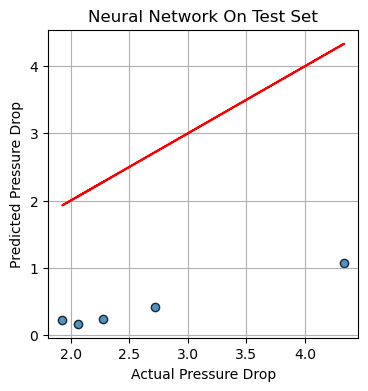

In [20]:
plt.figure(figsize=(4,4))
plt.scatter(targets, preds, alpha=0.8, edgecolors='black')
plt.plot(targets, targets, color='red')
plt.xlabel("Actual Pressure Drop")
plt.ylabel("Predicted Pressure Drop")
plt.title("Neural Network On Test Set")
plt.grid()
plt.show()

In [25]:
rf_preds = rf_model.predict(test_set.xs)
mae(tensor(rf_preds), tensor(test_set.y))

TensorBase(2.0356)

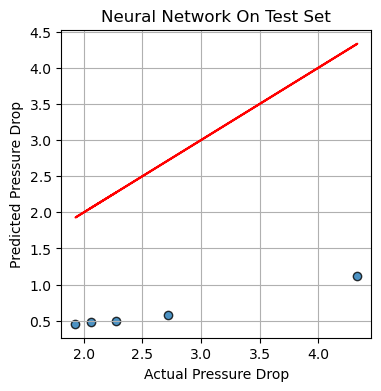

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(targets, rf_preds, alpha=0.8, edgecolors='black')
plt.plot(targets, targets, color='red')
plt.xlabel("Actual Pressure Drop")
plt.ylabel("Predicted Pressure Drop")
plt.title("Random Forest On Test Set")
plt.grid()
plt.show()